In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np
import re
import ast

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

## Data

### Read data

In [24]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")    
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")
smote2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote3_data.csv")
GAN2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN3_data.csv")    
borderline2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline3_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")


""" #undersampling prepare data //mixed data (gan, brdsmote, smote)
cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")
if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")
nm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")
median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")
lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") """


' #undersampling prepare data //mixed data (gan, brdsmote, smote)\ncc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")\nif_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")\nnm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")\nmedian_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")\nlof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") '

In [25]:
print(original_data["target"].value_counts())
count1=original_data["target"].value_counts().sum()
print(count1)
count2=abs((original_data['target']==0).sum() - (original_data['target']==1).sum())
print(f"Before undersampling: {count2}")
print(f"After number of samples: {count1+count2}")

target
0    151
1     46
Name: count, dtype: int64
197
Before undersampling: 105
After number of samples: 302


### Preprocessing Data

In [26]:
#mixed data
mix_data = pd.concat([GAN_data, smote_data, borderline_data, original_data], axis=0, ignore_index=True)         
mix_data = mix_data.reset_index(drop=True)

#data with one oversampling method and original data e.g.(smote+original)
smote_data = pd.concat([smote_data, smote2_data, original_data], axis=0, ignore_index=True)
smote_data = smote_data.reset_index(drop=True)
borderline_data = pd.concat([borderline_data, borderline2_data, original_data], axis=0, ignore_index=True)
borderline_data = borderline_data.reset_index(drop=True)
GAN_data = pd.concat([GAN_data, GAN2_data, original_data], axis=0, ignore_index=True)
GAN_data = GAN_data.reset_index(drop=True)

sum_all_data = pd.concat([smote_data, GAN_data, borderline_data, mix_data], axis=0, ignore_index=True)

#### Split data

In [27]:
X_mix, y_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_smote, y_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_GAN, y_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_borderline, y_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

#### Dictionary

In [28]:
data = {}
data["mix"] = (X_mix, y_mix)
data["smote"] = (X_smote, y_smote)
data["GAN"] = (X_GAN, y_GAN)
data["borderline"] = (X_borderline, y_borderline)

compare = {}
compare["mix"] = mix_data
compare["smote"] = smote_data
compare["GAN"] = GAN_data
compare["borderline"] = borderline_data

## Undersampling

### NearMiss version1

In [29]:
NM = NearMiss(version=1)

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_NM, y_NM = NM.fit_resample(X_train, y_train)
    
    #concat resampled data
    nearmiss_data = pd.concat([X_NM, y_NM], axis=1)
    
    NM_data_nosource = compare_df.drop(columns=["source"])
    nearmiss_data_nosource = nearmiss_data

    for index, row in nearmiss_data_nosource.iterrows():
        match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
        if match.any():  # Jeśli znaleziono dopasowanie
            matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
            nearmiss_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    nearmiss_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_NM_data.csv")
    
    print(f"Data reduced for {name} data")
    print(nearmiss_data["target"].value_counts())
    

Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64
Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


### K-means

In [30]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    X_majority_reduced = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    y_majority_reduced = pd.Series([0] * (int)((count1+count2)/2), name="target")
    
    X_minority = X_minority.reset_index(drop=True)
    y_minority = pd.Series([1] * len(X_minority), name="target")
    
    X_final = pd.concat([X_majority_reduced, X_minority], axis=0).reset_index(drop=True)
    y_final = pd.concat([y_majority_reduced, y_minority], axis=0).reset_index(drop=True)
    
    # Concat resampled data
    reduced_data = pd.concat([X_final, y_final], axis=1)
    
    reduced_data["source"] = None  # Initialize the source column with None
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"       
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


### ClusterCentroids

In [31]:
CC = ClusterCentroids(sampling_strategy="majority", voting="auto")

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_CC, y_CC = CC.fit_resample(X_train, y_train)
    
    # Concat resampled data
    reduced_data = pd.concat([X_CC, y_CC], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data.drop(columns=["source"], errors='ignore')

    reduced_data["source"] = None  # Initialize the source column with None

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_CC_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
0    151
1    151
Name: count, dtype: int64


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
0    151
1    151
Name: count, dtype: int64


## Learning

### Data after reduced

In [53]:
#NearMiss reduced data
mix_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_NM_data.csv")
smote_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_NM_data.csv")
GAN_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_NM_data.csv")
borderline_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_NM_data.csv")

#KMeans reduced data
mix_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_KM_data.csv")
smote_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_KM_data.csv")
GAN_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_KM_data.csv")
borderline_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_KM_data.csv")

#ClusterCentroids reduced data
mix_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_CC_data.csv")
smote_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_CC_data.csv")
GAN_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_CC_data.csv")
borderline_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_CC_data.csv")

X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")

In [54]:
# Lista wszystkich zbiorów danych
all_reduced_datasets = [
    mix_NM_data, smote_NM_data, GAN_NM_data, borderline_NM_data,
    mix_KM_data, smote_KM_data, GAN_KM_data, borderline_KM_data,
    mix_CC_data, smote_CC_data, GAN_CC_data, borderline_CC_data, X_test, y_test
]

# Usuń kolumnę 'Unnamed: 0' jeśli istnieje
for i, df in enumerate(all_reduced_datasets):
    if 'Unnamed: 0' in df.columns:
        all_reduced_datasets[i] = df.drop(columns=['Unnamed: 0'])

# Przypisz z powrotem do zmiennych (jeśli chcesz dalej używać tych samych nazw)
(
    mix_NM_data, smote_NM_data, GAN_NM_data, borderline_NM_data,
    mix_KM_data, smote_KM_data, GAN_KM_data, borderline_KM_data,
    mix_CC_data, smote_CC_data, GAN_CC_data, borderline_CC_data, X_test, y_test
) = all_reduced_datasets

In [55]:
data = {
    "mix_NM": mix_NM_data,
    "smote_NM": smote_NM_data,
    "GAN_NM": GAN_NM_data,
    "borderline_NM": borderline_NM_data,
    "mix_KM": mix_KM_data,
    "smote_KM": smote_KM_data,
    "GAN_KM": GAN_KM_data,
    "borderline_KM": borderline_KM_data,
    "mix_CC": mix_CC_data,
    "smote_CC": smote_CC_data,
    "GAN_CC": GAN_CC_data,
    "borderline_CC": borderline_CC_data
}

#split data
X_train_ = {}
y_train_ = {}

for name in data:
    X_train_[name] = data[name].drop(columns=["target", "source"])
    y_train_[name] = data[name]["target"]

#define models    
model_classes = {
    "LR": LogisticRegression,
    "DT": DecisionTreeClassifier,
    "RF": RandomForestClassifier,
    "XGB": XGBClassifier,
    "XGBRF": XGBRFClassifier
}

#define data variants
data_variants = [
    "mix_NM", "smote_NM", "GAN_NM", "borderline_NM",
    "mix_KM", "smote_KM", "GAN_KM", "borderline_KM",
    "mix_CC", "smote_CC", "GAN_CC", "borderline_CC"
]

models = {}

for model_name, model_class in model_classes.items():
    for variant in data_variants:
        key = f"{model_name}_{variant}"
        models[key] = model_class()
        
training_data = {}

for model_key in models.keys():
    if "_" in model_key:
        base_model_name = model_key.split("_")[0]
    else:
        base_model_name = model_key

    for data_key in data.keys():
        full_key = f"{base_model_name}_{data_key}" if data_key else base_model_name
        training_data[full_key] = (X_train_[data_key], y_train_[data_key])

### GridSearch

In [ ]:
params_ = {
    "LR": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]
    },
    "DT": {
        'max_depth': [4, 8, 12, 16],
        'random_state': [0, 10, 20, 30, 40],
        'min_samples_leaf': [1, 2]
    },
    "RF": {
        'n_estimators': [20, 40, 60, 80, 100],
        'max_depth': [4, 8, 12, 16],
        'min_samples_leaf': [1, 2],
        'random_state': [0, 10, 20, 30, 40]
    },
    "XGB": {
        'max_depth': [4, 8, 12, 16],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
    },
    "XGBRF": {
        'max_depth': [4, 8, 12, 16],
        'n_estimators': [20, 40, 60, 80, 100],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'random_state': [0, 10, 20, 30, 40]
    }
}

goal = ['accuracy','precision', 'recall', 'f1'] 
file_pathes = ["D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\accuracy.txt"
                ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\precision.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\recall.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\f1.txt"]

best_prams = {}

for score_1, file_path in zip(goal, file_pathes):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        data = training_data[data_key]
        
        param_grid = None
        for key in params_.keys():
            if model_key.startswith(key):
                param_grid = params_[key]
                break
        
        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid=param_grid, scoring=score_1, n_jobs=1).fit(data[0], data[1])
            print(f"{score_1} & {model_key}")
            with open(file_path, "a+") as f:
                print(f'scoring: {score_1}', file=f)
                print(f'Best parameters for {score_1} & {model_key}:', grid_search.best_params_, file=f)
                print(f'Best score for {score_1} & {model_key}:', grid_search.best_score_, file=f)
                
            best_prams[f"{model_key}_{score_1}"] = grid_search.best_estimator_

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_borderline_CC
accuracy & DT_mix_NM
accuracy & DT_smote_NM
accuracy & DT_GAN_NM
accuracy & DT_borderline_NM
accuracy & DT_mix_KM
accuracy & DT_smote_KM
accuracy & DT_GAN_KM
accuracy & DT_borderline_KM
accuracy & DT_mix_CC
accuracy & DT_smote_CC
accuracy & DT_GAN_CC
accuracy & DT_borderline_CC
accuracy & RF_mix_NM
accuracy & RF_smote_NM
accuracy & RF_GAN_NM
accuracy & RF_borderline_NM
accuracy & RF_mix_KM
accuracy & RF_smote_KM
accuracy & RF_GAN_KM
accuracy & RF_borderline_KM
accuracy & RF_mix_CC
accuracy & RF_smote_CC
accuracy & RF_GAN_CC
accuracy & RF_borderline_CC
accuracy & XGB_mix_NM
accuracy & XGB_smote_NM
accuracy & XGB_GAN_NM
accuracy & XGB_borderline_NM
accuracy & XGB_mix_KM
accuracy & XGB_smote_KM
accuracy & XGB_GAN_KM
accuracy & XGB_borderline_KM
accuracy & XGB_mix_CC
accuracy & XGB_smote_CC
accuracy & XGB_GAN_CC
accuracy & XGB_borderline_CC
accuracy & XGBRF_mix_NM
accuracy & XGBRF_smote_NM
accuracy & XGBRF_GAN_NM
accuracy & XGBRF_borderline_NM
accuracy & XGBRF_m

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_borderline_CC
precision & DT_mix_NM
precision & DT_smote_NM
precision & DT_GAN_NM
precision & DT_borderline_NM
precision & DT_mix_KM
precision & DT_smote_KM
precision & DT_GAN_KM
precision & DT_borderline_KM
precision & DT_mix_CC
precision & DT_smote_CC
precision & DT_GAN_CC
precision & DT_borderline_CC
precision & RF_mix_NM
precision & RF_smote_NM
precision & RF_GAN_NM
precision & RF_borderline_NM
precision & RF_mix_KM
precision & RF_smote_KM
precision & RF_GAN_KM
precision & RF_borderline_KM
precision & RF_mix_CC
precision & RF_smote_CC
precision & RF_GAN_CC
precision & RF_borderline_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGB_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGB_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGB_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGB_borderline_NM
precision & XGB_mix_KM
precision & XGB_smote_KM
precision & XGB_GAN_KM
precision & XGB_borderline_KM
precision & XGB_mix_CC
precision & XGB_smote_CC
precision & XGB_GAN_CC
precision & XGB_borderline_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGBRF_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGBRF_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGBRF_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\metrics\_classi

precision & XGBRF_borderline_NM
precision & XGBRF_mix_KM
precision & XGBRF_smote_KM
precision & XGBRF_GAN_KM
precision & XGBRF_borderline_KM
precision & XGBRF_mix_CC
precision & XGBRF_smote_CC
precision & XGBRF_GAN_CC
precision & XGBRF_borderline_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_borderline_CC
recall & DT_mix_NM
recall & DT_smote_NM
recall & DT_GAN_NM
recall & DT_borderline_NM
recall & DT_mix_KM
recall & DT_smote_KM
recall & DT_GAN_KM
recall & DT_borderline_KM
recall & DT_mix_CC
recall & DT_smote_CC
recall & DT_GAN_CC
recall & DT_borderline_CC
recall & RF_mix_NM
recall & RF_smote_NM
recall & RF_GAN_NM
recall & RF_borderline_NM
recall & RF_mix_KM
recall & RF_smote_KM
recall & RF_GAN_KM
recall & RF_borderline_KM
recall & RF_mix_CC
recall & RF_smote_CC
recall & RF_GAN_CC
recall & RF_borderline_CC
recall & XGB_mix_NM
recall & XGB_smote_NM
recall & XGB_GAN_NM
recall & XGB_borderline_NM
recall & XGB_mix_KM
recall & XGB_smote_KM
recall & XGB_GAN_KM
recall & XGB_borderline_KM
recall & XGB_mix_CC
recall & XGB_smote_CC
recall & XGB_GAN_CC
recall & XGB_borderline_CC
recall & XGBRF_mix_NM
recall & XGBRF_smote_NM
recall & XGBRF_GAN_NM
recall & XGBRF_borderline_NM
recall & XGBRF_mix_KM
recall & XGBRF_smote_KM
recall & XGBRF_GAN_KM
recall & XGBRF_borderline_KM
rec

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_borderline_CC
f1 & DT_mix_NM
f1 & DT_smote_NM
f1 & DT_GAN_NM
f1 & DT_borderline_NM
f1 & DT_mix_KM
f1 & DT_smote_KM
f1 & DT_GAN_KM
f1 & DT_borderline_KM
f1 & DT_mix_CC
f1 & DT_smote_CC
f1 & DT_GAN_CC
f1 & DT_borderline_CC
f1 & RF_mix_NM
f1 & RF_smote_NM
f1 & RF_GAN_NM
f1 & RF_borderline_NM
f1 & RF_mix_KM
f1 & RF_smote_KM
f1 & RF_GAN_KM
f1 & RF_borderline_KM
f1 & RF_mix_CC
f1 & RF_smote_CC
f1 & RF_GAN_CC
f1 & RF_borderline_CC
f1 & XGB_mix_NM
f1 & XGB_smote_NM
f1 & XGB_GAN_NM
f1 & XGB_borderline_NM
f1 & XGB_mix_KM
f1 & XGB_smote_KM
f1 & XGB_GAN_KM
f1 & XGB_borderline_KM
f1 & XGB_mix_CC
f1 & XGB_smote_CC
f1 & XGB_GAN_CC
f1 & XGB_borderline_CC
f1 & XGBRF_mix_NM
f1 & XGBRF_smote_NM
f1 & XGBRF_GAN_NM
f1 & XGBRF_borderline_NM
f1 & XGBRF_mix_KM
f1 & XGBRF_smote_KM
f1 & XGBRF_GAN_KM
f1 & XGBRF_borderline_KM
f1 & XGBRF_mix_CC
f1 & XGBRF_smote_CC
f1 & XGBRF_GAN_CC
f1 & XGBRF_borderline_CC


### Learning Models Cross-Vali

In [56]:
# Function to extract parameters from text file
def extract_params_from_file(file_path):
    params = {}
    with open(file_path, 'r') as file:
        content = file.read()

    # Lepszy regex z zabezpieczeniem końca
    matches = re.findall(
        r'Best parameters for accuracy & ([\w_]+):\s*({.*?})(?:\nBest score|\Z)',
        content,
        re.DOTALL
    )

    for match in matches:
        key, param_str = match
        try:
            param_dict = ast.literal_eval(param_str)
            params[key] = param_dict
        except Exception as e:
            print(f"[!] Error parsing params for {key}: {e}")

    return params

# Extract parameters from text files
accuracy_params = extract_params_from_file("D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\old\\accuracy.txt")

# Update the models dictionary with the best models
models = {key: model_classes[key.split('_')[0]]().set_params(**params) for key, params in accuracy_params.items()}

# Display the resulting models dictionary
for key, model in models.items():
    print(f"Training {key}: {model}")
    

Training LR_mix_NM: LogisticRegression(random_state=0)
Training LR_smote_NM: LogisticRegression(random_state=0)
Training LR_GAN_NM: LogisticRegression(random_state=0)
Training LR_borderline_NM: LogisticRegression(random_state=0)
Training LR_mix_KM: LogisticRegression(max_iter=500, random_state=0)
Training LR_smote_KM: LogisticRegression(max_iter=500, random_state=0)
Training LR_GAN_KM: LogisticRegression(random_state=0)
Training LR_borderline_KM: LogisticRegression(max_iter=500, random_state=0)
Training LR_mix_CC: LogisticRegression(max_iter=500, random_state=0)
Training LR_smote_CC: LogisticRegression(max_iter=1000, random_state=0)
Training LR_GAN_CC: LogisticRegression(random_state=0)
Training LR_borderline_CC: LogisticRegression(max_iter=500, random_state=0)
Training DT_mix_NM: DecisionTreeClassifier(max_depth=4, random_state=0)
Training DT_smote_NM: DecisionTreeClassifier(max_depth=4, random_state=0)
Training DT_GAN_NM: DecisionTreeClassifier(max_depth=4, random_state=0)
Training D

In [57]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean_under=[]
results_cross_std_under=[]
goal = ['accuracy', 'precision','f1','recall']
path_files = ["D:\\ml\\undersampling_data\\reports\\ssh\\results\\accuracy_metrics.txt",
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\precision_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\f1_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\recall_metrics.txt"]

excel_file_cross = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross.xlsx"
excel_file_cross2 = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross_std.xlsx"
name_sheet1 = "Arkusz1"

model_scores = {}

for metrix1, path_file in zip(goal, path_files):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        X_train, y_train = training_data[model_key]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_key}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_key} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)
        
        results_cross_mean_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_under_mean = pd.DataFrame(results_cross_mean_under)
        df_results_cross_under_std = pd.DataFrame(results_cross_std_under)
        df_save_under_mean = df_results_cross_under_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_under_std = df_results_cross_under_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_under_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_under_std.to_excel(w1, sheet_name=name_sheet1)


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_borderline_CC
Learn: accuracy and model DT_mix_NM
Learn: accuracy and model DT_smote_NM
Learn: accuracy and model DT_GAN_NM
Learn: accuracy and model DT_borderline_NM
Learn: accuracy and model DT_mix_KM
Learn: accuracy and model DT_smote_KM
Learn: accuracy and model DT_GAN_KM
Learn: accuracy and model DT_borderline_KM
Learn: accuracy and model DT_mix_CC
Learn: accuracy and model DT_smote_CC
Learn: accuracy and model DT_GAN_CC
Learn: accuracy and model DT_borderline_CC
Learn: accuracy and model RF_mix_NM
Learn: accuracy and model RF_smote_NM
Learn: accuracy and model RF_GAN_NM
Learn: accuracy and model RF_borderline_NM
Learn: accuracy and model RF_mix_KM
Learn: accuracy and model RF_smote_KM
Learn: accuracy and model RF_GAN_KM
Learn: accuracy and model RF_borderline_KM
Learn: accuracy and model RF_mix_CC
Learn: accuracy and model RF_smote_CC
Learn: accuracy and model RF_GAN_CC
Learn: accuracy and model RF_borderline_CC
Learn: accuracy and model XGB_mix_NM
Le

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_borderline_CC
Learn: precision and model DT_mix_NM
Learn: precision and model DT_smote_NM
Learn: precision and model DT_GAN_NM
Learn: precision and model DT_borderline_NM
Learn: precision and model DT_mix_KM
Learn: precision and model DT_smote_KM
Learn: precision and model DT_GAN_KM
Learn: precision and model DT_borderline_KM
Learn: precision and model DT_mix_CC
Learn: precision and model DT_smote_CC
Learn: precision and model DT_GAN_CC
Learn: precision and model DT_borderline_CC
Learn: precision and model RF_mix_NM
Learn: precision and model RF_smote_NM
Learn: precision and model RF_GAN_NM
Learn: precision and model RF_borderline_NM
Learn: precision and model RF_mix_KM
Learn: precision and model RF_smote_KM
Learn: precision and model RF_GAN_KM
Learn: precision and model RF_borderline_KM
Learn: precision and model RF_mix_CC
Learn: precision and model RF_smote_CC
Learn: precision and model RF_GAN_CC
Learn: precision and model RF_borderline_CC
Learn: precisi

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_borderline_CC
Learn: f1 and model DT_mix_NM
Learn: f1 and model DT_smote_NM
Learn: f1 and model DT_GAN_NM
Learn: f1 and model DT_borderline_NM
Learn: f1 and model DT_mix_KM
Learn: f1 and model DT_smote_KM
Learn: f1 and model DT_GAN_KM
Learn: f1 and model DT_borderline_KM
Learn: f1 and model DT_mix_CC
Learn: f1 and model DT_smote_CC
Learn: f1 and model DT_GAN_CC
Learn: f1 and model DT_borderline_CC
Learn: f1 and model RF_mix_NM
Learn: f1 and model RF_smote_NM
Learn: f1 and model RF_GAN_NM
Learn: f1 and model RF_borderline_NM
Learn: f1 and model RF_mix_KM
Learn: f1 and model RF_smote_KM
Learn: f1 and model RF_GAN_KM
Learn: f1 and model RF_borderline_KM
Learn: f1 and model RF_mix_CC
Learn: f1 and model RF_smote_CC
Learn: f1 and model RF_GAN_CC
Learn: f1 and model RF_borderline_CC
Learn: f1 and model XGB_mix_NM
Learn: f1 and model XGB_smote_NM
Learn: f1 and model XGB_GAN_NM
Learn: f1 and model XGB_borderline_NM
Learn: f1 and model XGB_mix_KM
Learn: f1 and model XGB_s

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_mix_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_smote_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_GAN_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_borderline_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_mix_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_smote_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_GAN_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_borderline_KM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_mix_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_smote_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_GAN_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_borderline_CC
Learn: recall and model DT_mix_NM
Learn: recall and model DT_smote_NM
Learn: recall and model DT_GAN_NM
Learn: recall and model DT_borderline_NM
Learn: recall and model DT_mix_KM
Learn: recall and model DT_smote_KM
Learn: recall and model DT_GAN_KM
Learn: recall and model DT_borderline_KM
Learn: recall and model DT_mix_CC
Learn: recall and model DT_smote_CC
Learn: recall and model DT_GAN_CC
Learn: recall and model DT_borderline_CC
Learn: recall and model RF_mix_NM
Learn: recall and model RF_smote_NM
Learn: recall and model RF_GAN_NM
Learn: recall and model RF_borderline_NM
Learn: recall and model RF_mix_KM
Learn: recall and model RF_smote_KM
Learn: recall and model RF_GAN_KM
Learn: recall and model RF_borderline_KM
Learn: recall and model RF_mix_CC
Learn: recall and model RF_smote_CC
Learn: recall and model RF_GAN_CC
Learn: recall and model RF_borderline_CC
Learn: recall and model XGB_mix_NM
Learn: recall and model XGB_smote_NM
Learn: recall and

### Save Models + Create Figures

In [58]:
for model_name, model in models.items():  
    name = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

Model LR_mix_NM saved in: D:\ml\undersampling_data\models\ssh\LR_mix_NM.joblib
Model LR_smote_NM saved in: D:\ml\undersampling_data\models\ssh\LR_smote_NM.joblib
Model LR_GAN_NM saved in: D:\ml\undersampling_data\models\ssh\LR_GAN_NM.joblib
Model LR_borderline_NM saved in: D:\ml\undersampling_data\models\ssh\LR_borderline_NM.joblib
Model LR_mix_KM saved in: D:\ml\undersampling_data\models\ssh\LR_mix_KM.joblib
Model LR_smote_KM saved in: D:\ml\undersampling_data\models\ssh\LR_smote_KM.joblib
Model LR_GAN_KM saved in: D:\ml\undersampling_data\models\ssh\LR_GAN_KM.joblib
Model LR_borderline_KM saved in: D:\ml\undersampling_data\models\ssh\LR_borderline_KM.joblib
Model LR_mix_CC saved in: D:\ml\undersampling_data\models\ssh\LR_mix_CC.joblib
Model LR_smote_CC saved in: D:\ml\undersampling_data\models\ssh\LR_smote_CC.joblib
Model LR_GAN_CC saved in: D:\ml\undersampling_data\models\ssh\LR_GAN_CC.joblib
Model LR_borderline_CC saved in: D:\ml\undersampling_data\models\ssh\LR_borderline_CC.jobli

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_mix_NM
[[60  5]
 [ 1 19]]
Classification Report for LR_mix_NM
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        65
           1       0.79      0.95      0.86        20

    accuracy                           0.93        85
   macro avg       0.89      0.94      0.91        85
weighted avg       0.94      0.93      0.93        85



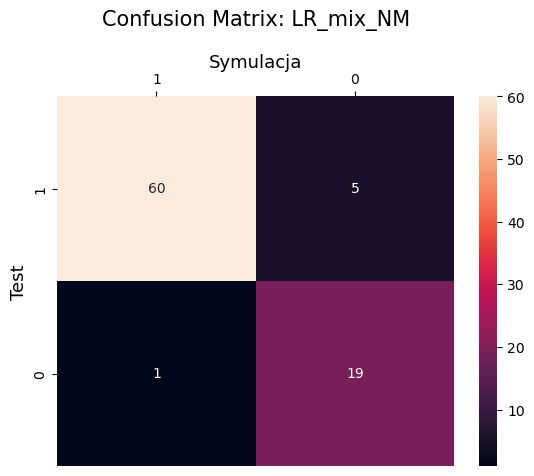

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_smote_NM
[[60  5]
 [ 1 19]]
Classification Report for LR_smote_NM
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        65
           1       0.79      0.95      0.86        20

    accuracy                           0.93        85
   macro avg       0.89      0.94      0.91        85
weighted avg       0.94      0.93      0.93        85



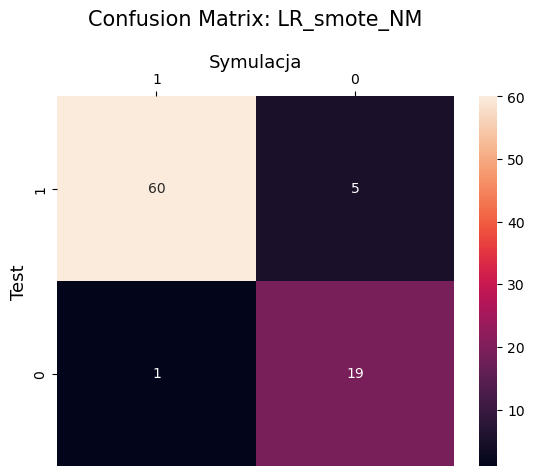

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_NM
[[63  2]
 [ 1 19]]
Classification Report for LR_GAN_NM
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        65
           1       0.90      0.95      0.93        20

    accuracy                           0.96        85
   macro avg       0.94      0.96      0.95        85
weighted avg       0.97      0.96      0.96        85



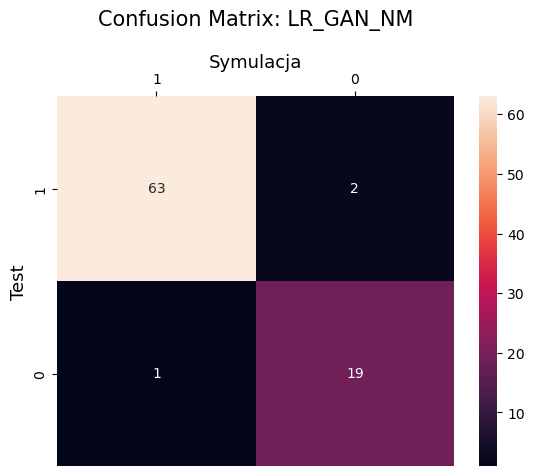

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_borderline_NM
[[61  4]
 [ 3 17]]
Classification Report for LR_borderline_NM
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        65
           1       0.81      0.85      0.83        20

    accuracy                           0.92        85
   macro avg       0.88      0.89      0.89        85
weighted avg       0.92      0.92      0.92        85



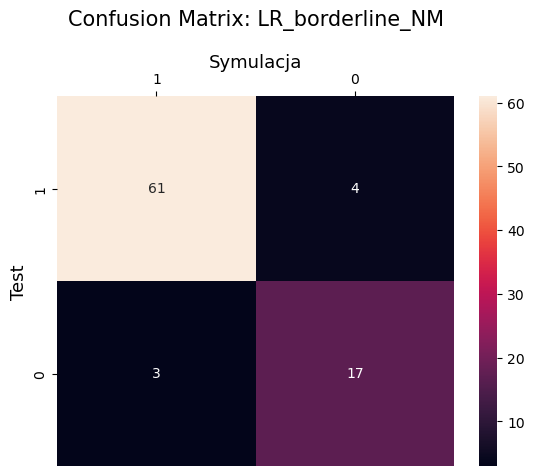

Confusion Matrix for LR_mix_KM
[[ 6 59]
 [20  0]]
Classification Report for LR_mix_KM
              precision    recall  f1-score   support

           0       0.23      0.09      0.13        65
           1       0.00      0.00      0.00        20

    accuracy                           0.07        85
   macro avg       0.12      0.05      0.07        85
weighted avg       0.18      0.07      0.10        85



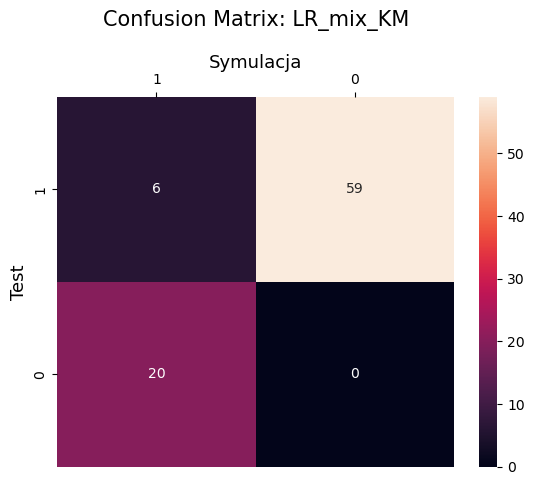

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_smote_KM
[[ 5 60]
 [20  0]]
Classification Report for LR_smote_KM
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        65
           1       0.00      0.00      0.00        20

    accuracy                           0.06        85
   macro avg       0.10      0.04      0.06        85
weighted avg       0.15      0.06      0.08        85



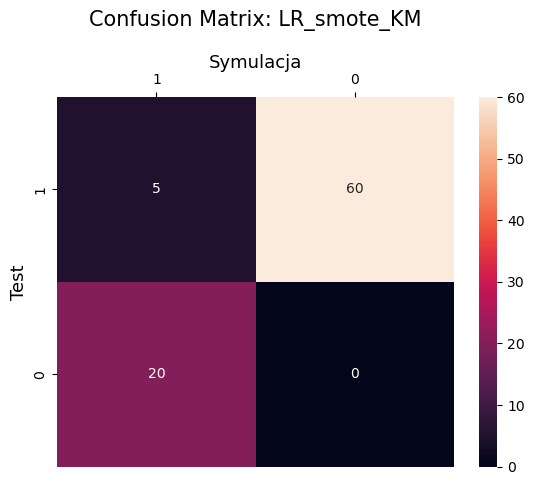

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_KM
[[ 3 62]
 [15  5]]
Classification Report for LR_GAN_KM
              precision    recall  f1-score   support

           0       0.17      0.05      0.07        65
           1       0.07      0.25      0.11        20

    accuracy                           0.09        85
   macro avg       0.12      0.15      0.09        85
weighted avg       0.15      0.09      0.08        85



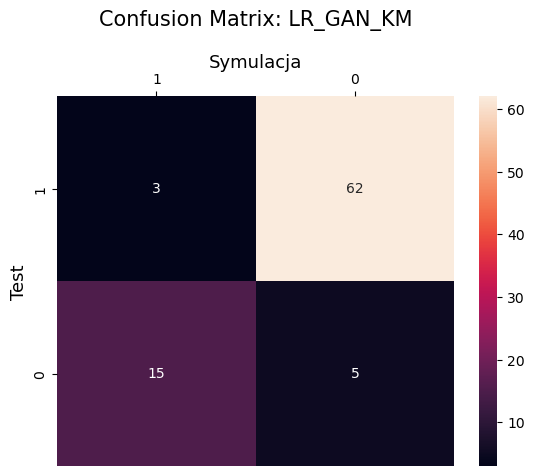

Confusion Matrix for LR_borderline_KM
[[ 6 59]
 [20  0]]
Classification Report for LR_borderline_KM
              precision    recall  f1-score   support

           0       0.23      0.09      0.13        65
           1       0.00      0.00      0.00        20

    accuracy                           0.07        85
   macro avg       0.12      0.05      0.07        85
weighted avg       0.18      0.07      0.10        85



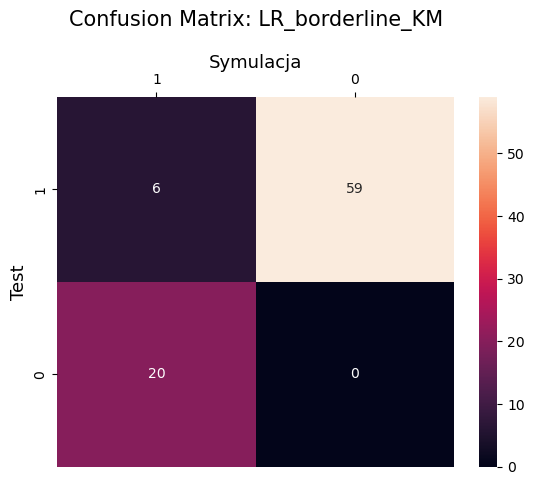

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_mix_CC
[[59  6]
 [ 1 19]]
Classification Report for LR_mix_CC
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        65
           1       0.76      0.95      0.84        20

    accuracy                           0.92        85
   macro avg       0.87      0.93      0.89        85
weighted avg       0.93      0.92      0.92        85



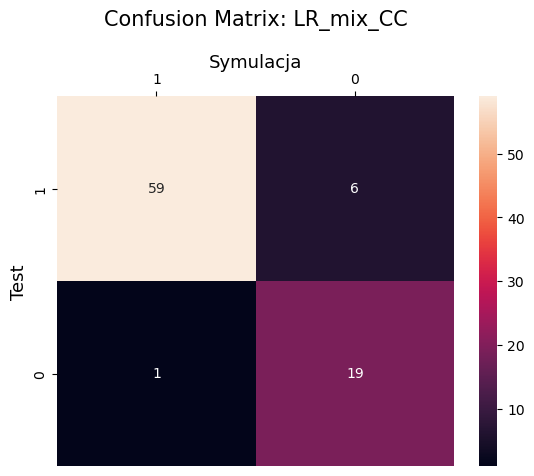

Confusion Matrix for LR_smote_CC
[[60  5]
 [ 0 20]]
Classification Report for LR_smote_CC
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        65
           1       0.80      1.00      0.89        20

    accuracy                           0.94        85
   macro avg       0.90      0.96      0.92        85
weighted avg       0.95      0.94      0.94        85



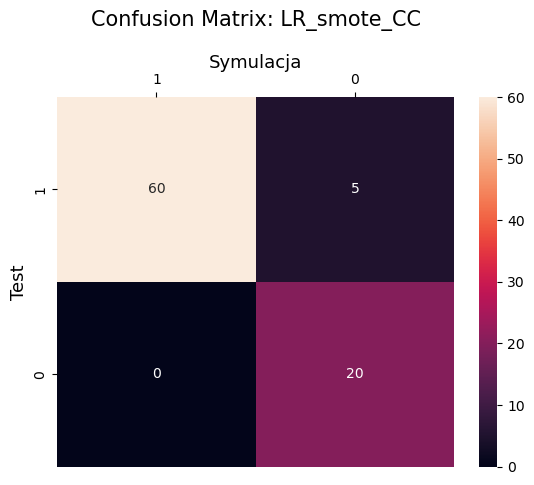

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_CC
[[63  2]
 [ 5 15]]
Classification Report for LR_GAN_CC
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        65
           1       0.88      0.75      0.81        20

    accuracy                           0.92        85
   macro avg       0.90      0.86      0.88        85
weighted avg       0.92      0.92      0.92        85



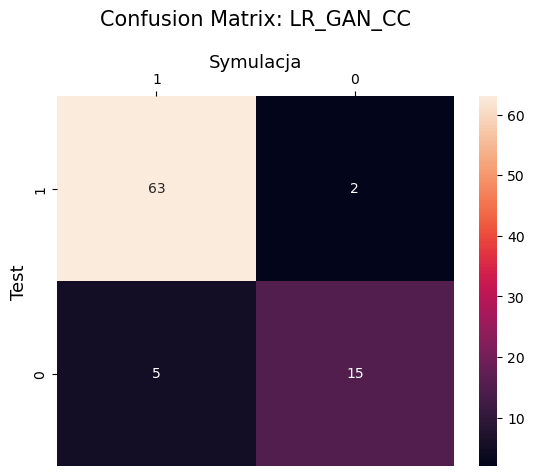

Confusion Matrix for LR_borderline_CC
[[58  7]
 [ 0 20]]
Classification Report for LR_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        65
           1       0.74      1.00      0.85        20

    accuracy                           0.92        85
   macro avg       0.87      0.95      0.90        85
weighted avg       0.94      0.92      0.92        85



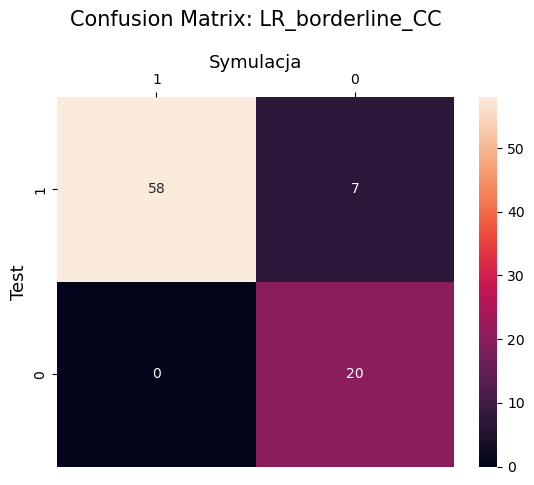

Confusion Matrix for DT_mix_NM
[[65  0]
 [ 1 19]]
Classification Report for DT_mix_NM
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      0.95      0.97        20

    accuracy                           0.99        85
   macro avg       0.99      0.97      0.98        85
weighted avg       0.99      0.99      0.99        85



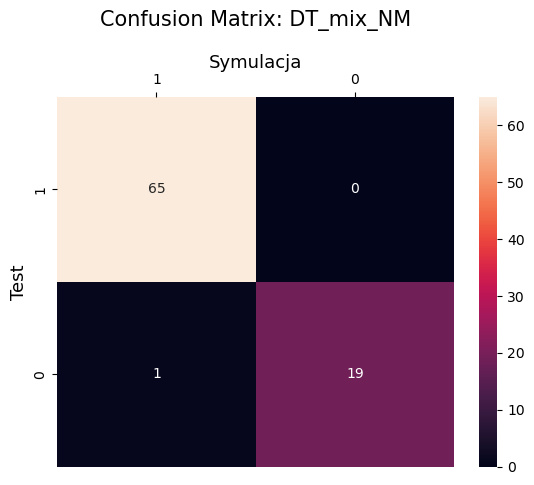

Confusion Matrix for DT_smote_NM
[[65  0]
 [ 1 19]]
Classification Report for DT_smote_NM
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      0.95      0.97        20

    accuracy                           0.99        85
   macro avg       0.99      0.97      0.98        85
weighted avg       0.99      0.99      0.99        85



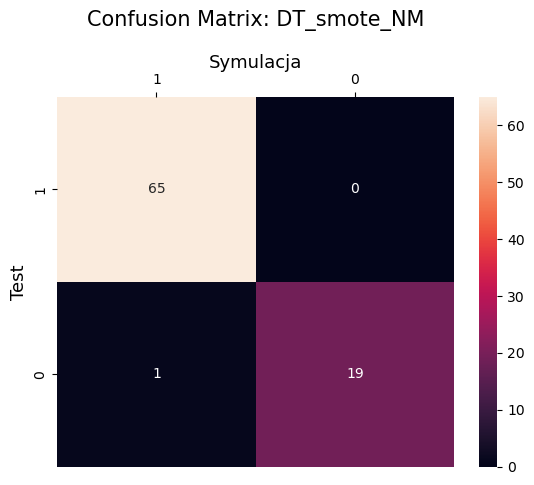

Confusion Matrix for DT_GAN_NM
[[59  6]
 [ 0 20]]
Classification Report for DT_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        65
           1       0.77      1.00      0.87        20

    accuracy                           0.93        85
   macro avg       0.88      0.95      0.91        85
weighted avg       0.95      0.93      0.93        85



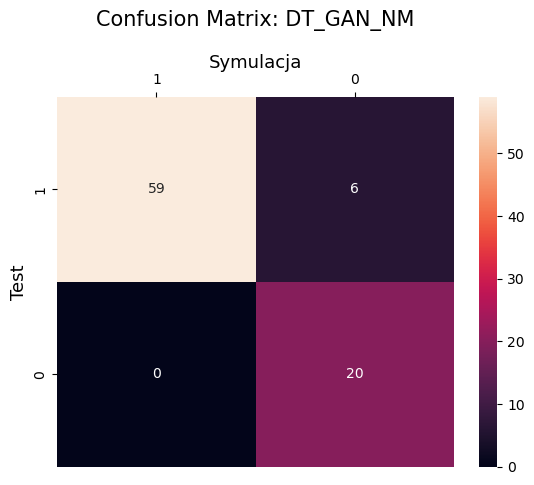

Confusion Matrix for DT_borderline_NM
[[65  0]
 [ 1 19]]
Classification Report for DT_borderline_NM
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      0.95      0.97        20

    accuracy                           0.99        85
   macro avg       0.99      0.97      0.98        85
weighted avg       0.99      0.99      0.99        85



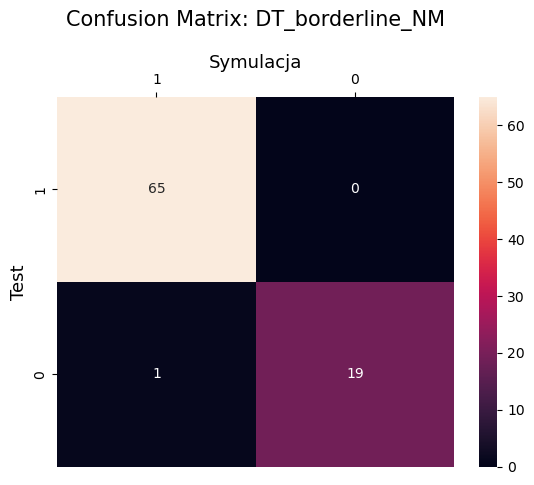

Confusion Matrix for DT_mix_KM
[[ 1 64]
 [19  1]]
Classification Report for DT_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.02      0.05      0.02        20

    accuracy                           0.02        85
   macro avg       0.03      0.03      0.02        85
weighted avg       0.04      0.02      0.02        85



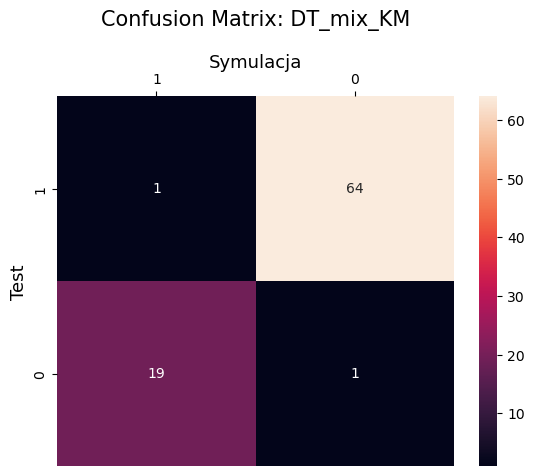

Confusion Matrix for DT_smote_KM
[[ 1 64]
 [19  1]]
Classification Report for DT_smote_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.02      0.05      0.02        20

    accuracy                           0.02        85
   macro avg       0.03      0.03      0.02        85
weighted avg       0.04      0.02      0.02        85



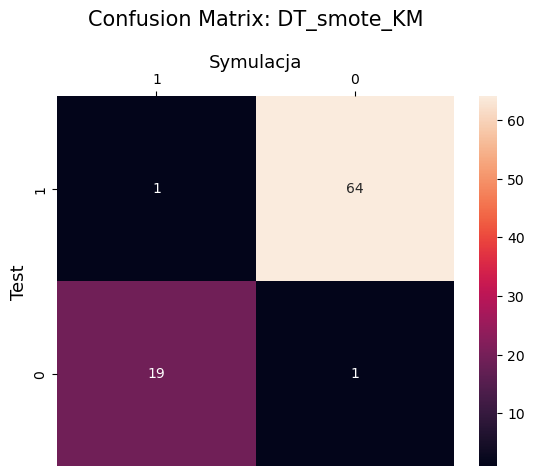

Confusion Matrix for DT_GAN_KM
[[ 1 64]
 [19  1]]
Classification Report for DT_GAN_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.02      0.05      0.02        20

    accuracy                           0.02        85
   macro avg       0.03      0.03      0.02        85
weighted avg       0.04      0.02      0.02        85



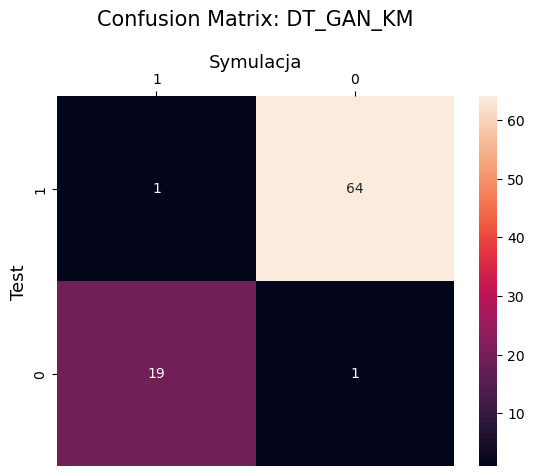

Confusion Matrix for DT_borderline_KM
[[ 3 62]
 [19  1]]
Classification Report for DT_borderline_KM
              precision    recall  f1-score   support

           0       0.14      0.05      0.07        65
           1       0.02      0.05      0.02        20

    accuracy                           0.05        85
   macro avg       0.08      0.05      0.05        85
weighted avg       0.11      0.05      0.06        85



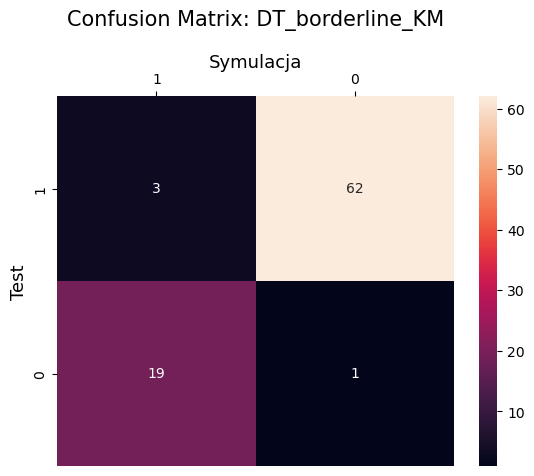

Confusion Matrix for DT_mix_CC
[[64  1]
 [ 1 19]]
Classification Report for DT_mix_CC
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



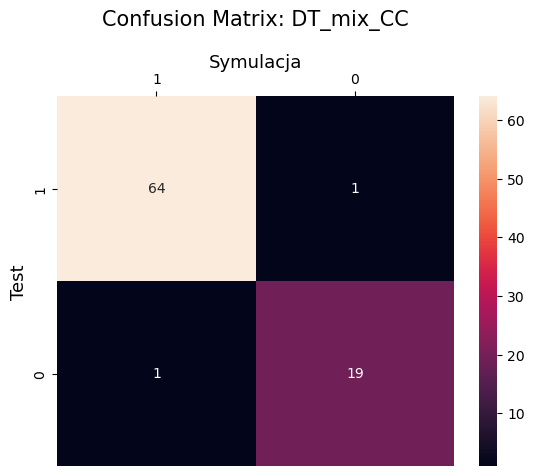

Confusion Matrix for DT_smote_CC
[[64  1]
 [ 1 19]]
Classification Report for DT_smote_CC
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.95      0.95      0.95        20

    accuracy                           0.98        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.98      0.98      0.98        85



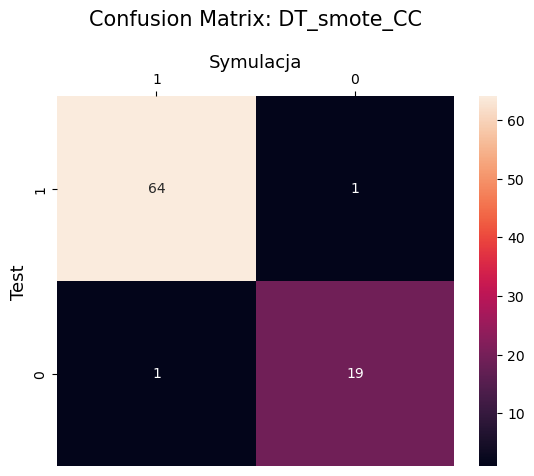

Confusion Matrix for DT_GAN_CC
[[64  1]
 [13  7]]
Classification Report for DT_GAN_CC
              precision    recall  f1-score   support

           0       0.83      0.98      0.90        65
           1       0.88      0.35      0.50        20

    accuracy                           0.84        85
   macro avg       0.85      0.67      0.70        85
weighted avg       0.84      0.84      0.81        85



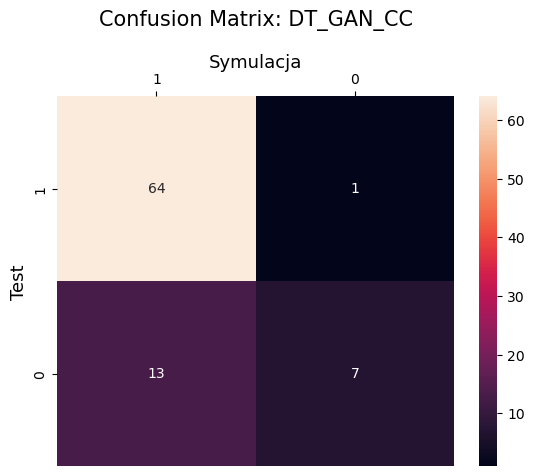

Confusion Matrix for DT_borderline_CC
[[65  0]
 [ 1 19]]
Classification Report for DT_borderline_CC
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        65
           1       1.00      0.95      0.97        20

    accuracy                           0.99        85
   macro avg       0.99      0.97      0.98        85
weighted avg       0.99      0.99      0.99        85



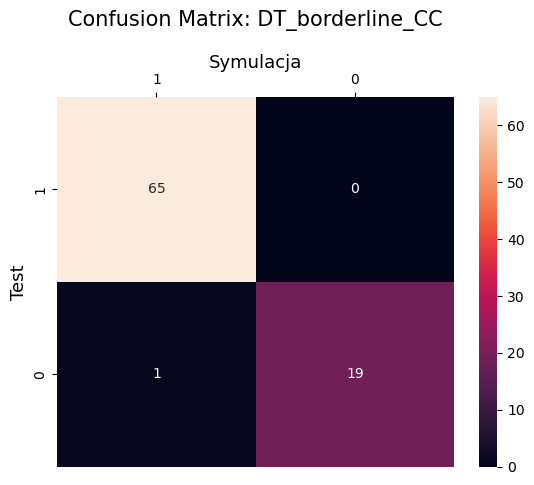

Confusion Matrix for RF_mix_NM
[[64  1]
 [ 0 20]]
Classification Report for RF_mix_NM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



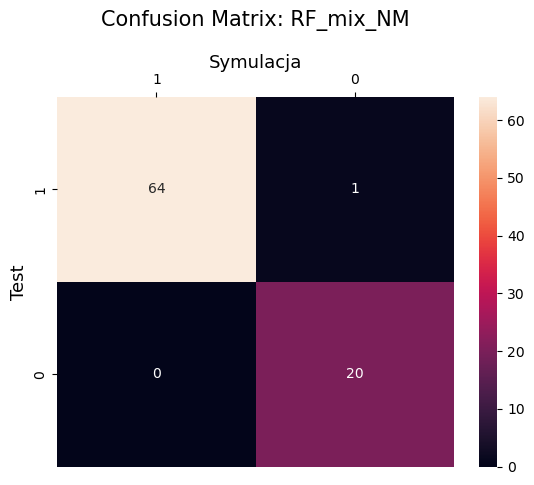

Confusion Matrix for RF_smote_NM
[[63  2]
 [ 0 20]]
Classification Report for RF_smote_NM
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



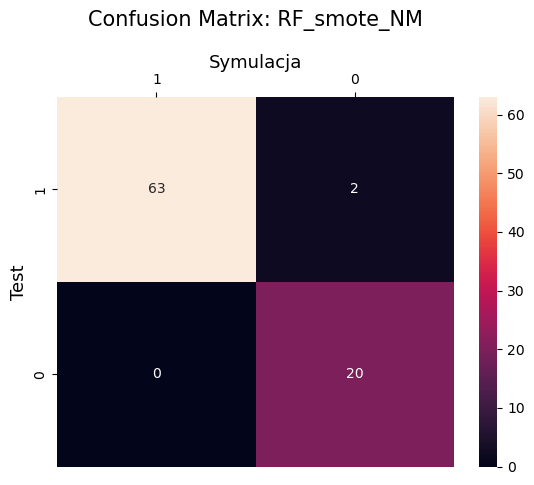

Confusion Matrix for RF_GAN_NM
[[62  3]
 [ 0 20]]
Classification Report for RF_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



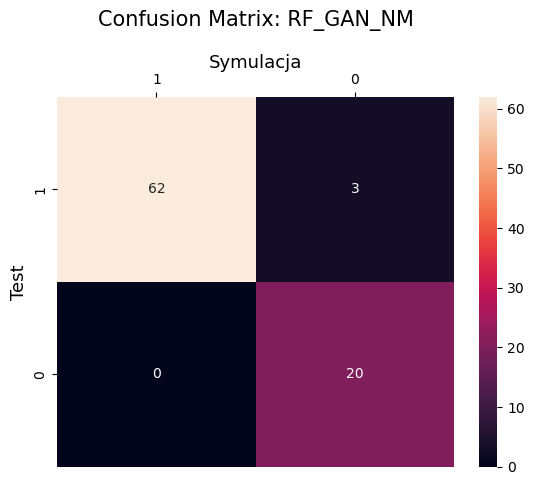

Confusion Matrix for RF_borderline_NM
[[63  2]
 [ 1 19]]
Classification Report for RF_borderline_NM
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        65
           1       0.90      0.95      0.93        20

    accuracy                           0.96        85
   macro avg       0.94      0.96      0.95        85
weighted avg       0.97      0.96      0.96        85



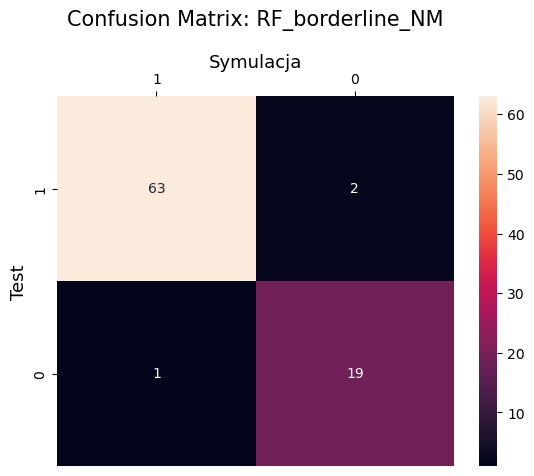

Confusion Matrix for RF_mix_KM
[[ 1 64]
 [20  0]]
Classification Report for RF_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.00      0.00      0.00        20

    accuracy                           0.01        85
   macro avg       0.02      0.01      0.01        85
weighted avg       0.04      0.01      0.02        85



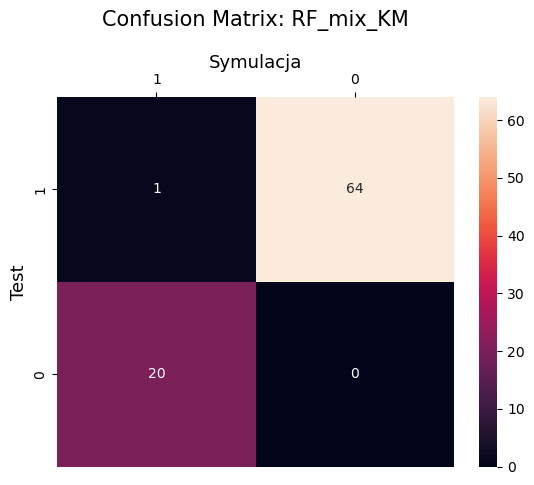

Confusion Matrix for RF_smote_KM
[[ 1 64]
 [20  0]]
Classification Report for RF_smote_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.00      0.00      0.00        20

    accuracy                           0.01        85
   macro avg       0.02      0.01      0.01        85
weighted avg       0.04      0.01      0.02        85



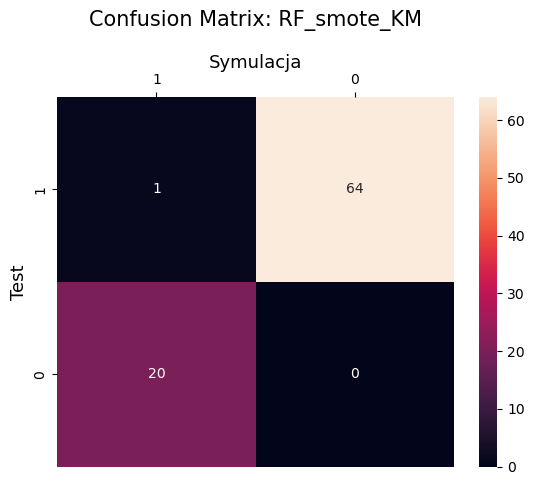

Confusion Matrix for RF_GAN_KM
[[ 0 65]
 [11  9]]
Classification Report for RF_GAN_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.12      0.45      0.19        20

    accuracy                           0.11        85
   macro avg       0.06      0.23      0.10        85
weighted avg       0.03      0.11      0.05        85



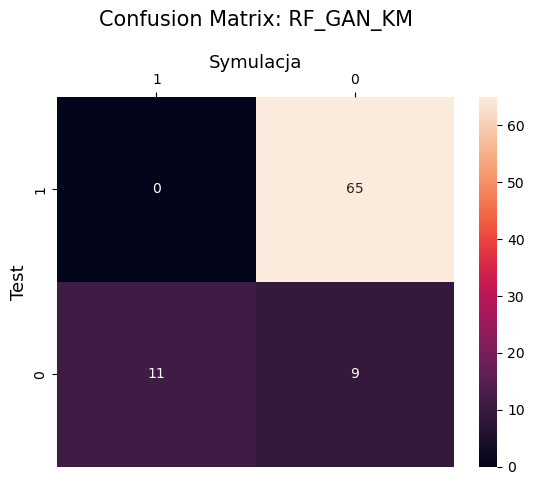

Confusion Matrix for RF_borderline_KM
[[ 3 62]
 [20  0]]
Classification Report for RF_borderline_KM
              precision    recall  f1-score   support

           0       0.13      0.05      0.07        65
           1       0.00      0.00      0.00        20

    accuracy                           0.04        85
   macro avg       0.07      0.02      0.03        85
weighted avg       0.10      0.04      0.05        85



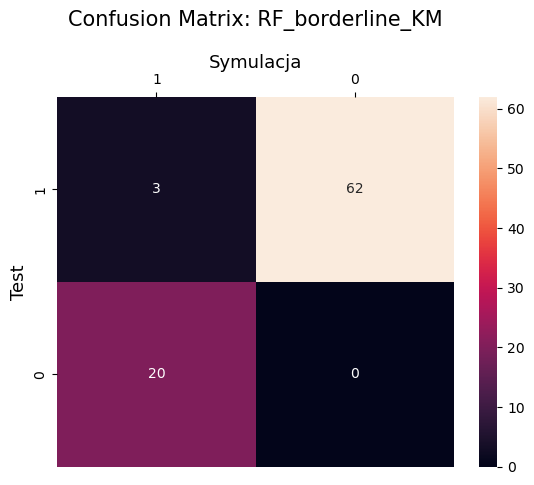

Confusion Matrix for RF_mix_CC
[[65  0]
 [ 2 18]]
Classification Report for RF_mix_CC
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        65
           1       1.00      0.90      0.95        20

    accuracy                           0.98        85
   macro avg       0.99      0.95      0.97        85
weighted avg       0.98      0.98      0.98        85



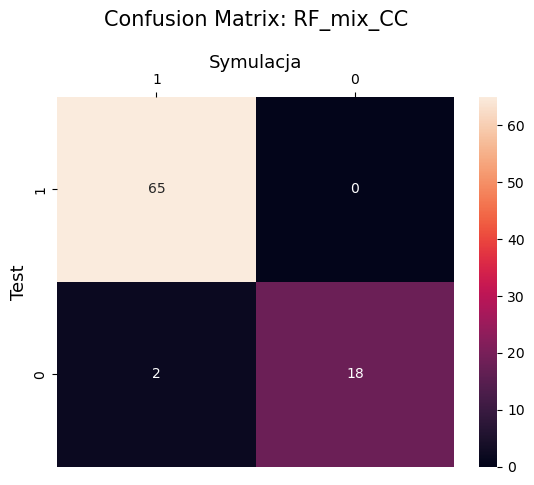

Confusion Matrix for RF_smote_CC
[[64  1]
 [ 0 20]]
Classification Report for RF_smote_CC
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



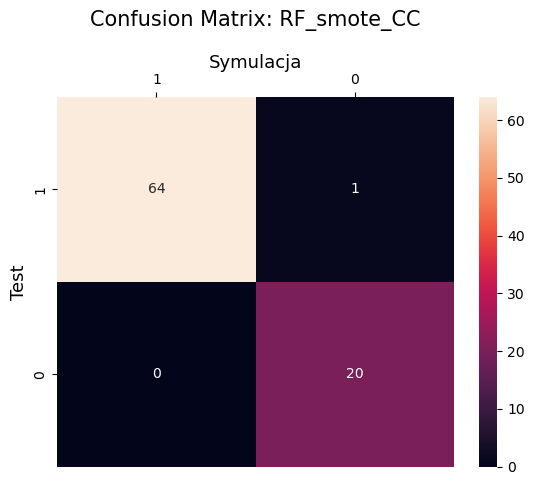

Confusion Matrix for RF_GAN_CC
[[64  1]
 [ 3 17]]
Classification Report for RF_GAN_CC
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.94      0.85      0.89        20

    accuracy                           0.95        85
   macro avg       0.95      0.92      0.93        85
weighted avg       0.95      0.95      0.95        85



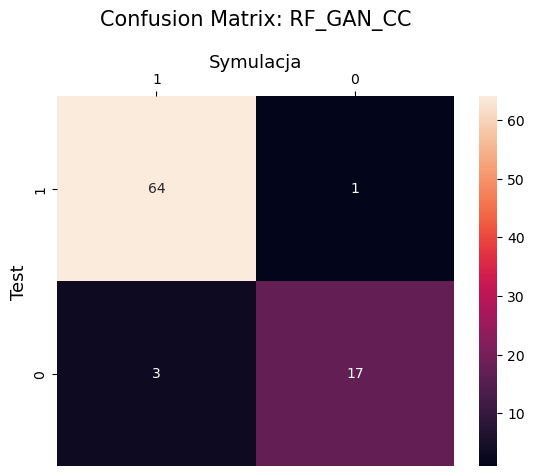

Confusion Matrix for RF_borderline_CC
[[62  3]
 [ 0 20]]
Classification Report for RF_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



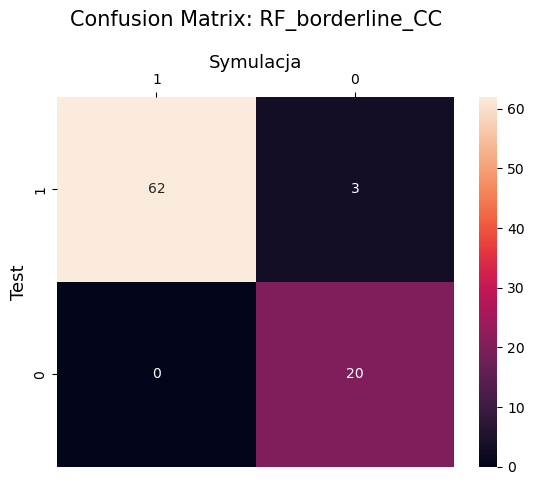

Confusion Matrix for XGB_mix_NM
[[63  2]
 [ 0 20]]
Classification Report for XGB_mix_NM
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



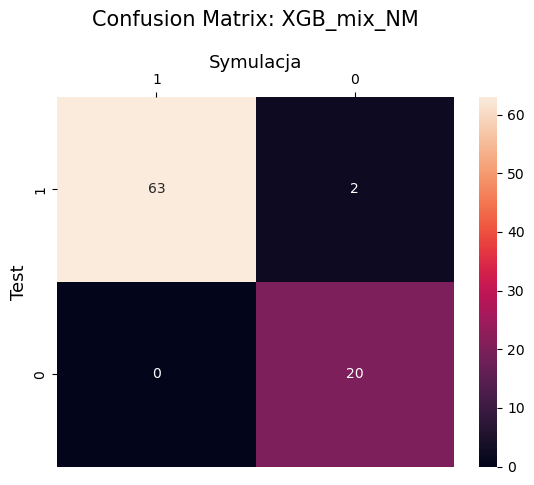

Confusion Matrix for XGB_smote_NM
[[64  1]
 [ 0 20]]
Classification Report for XGB_smote_NM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



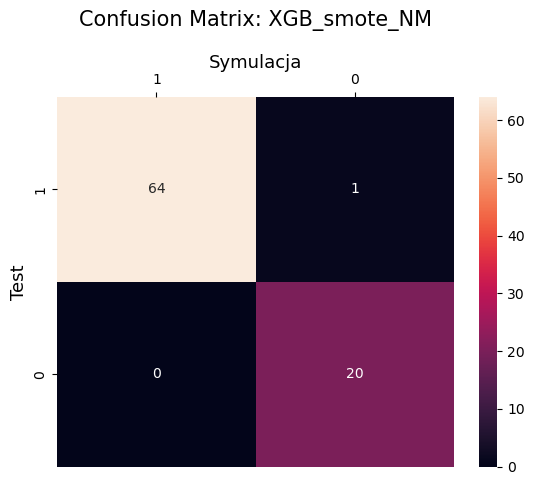

Confusion Matrix for XGB_GAN_NM
[[63  2]
 [ 0 20]]
Classification Report for XGB_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



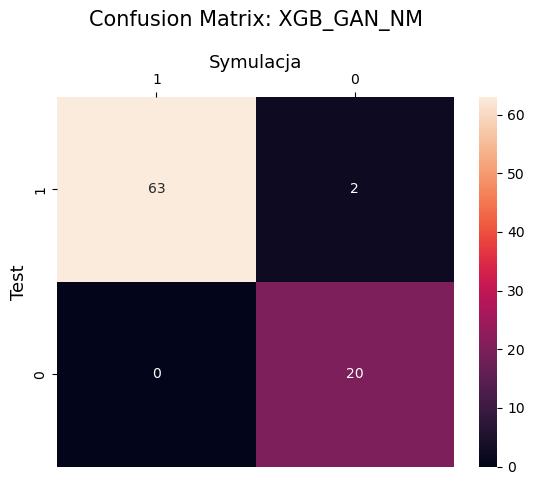

Confusion Matrix for XGB_borderline_NM
[[64  1]
 [ 0 20]]
Classification Report for XGB_borderline_NM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



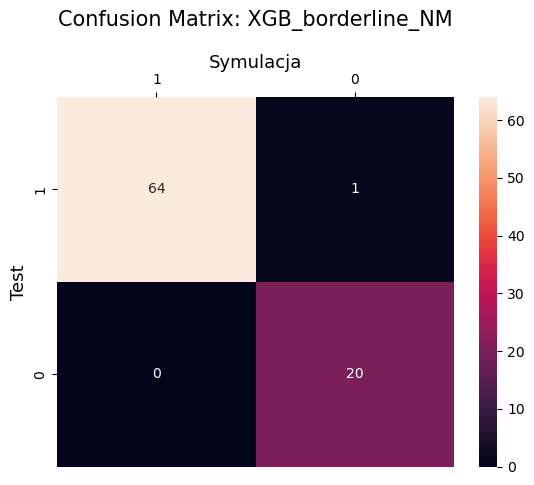

Confusion Matrix for XGB_mix_KM
[[ 1 64]
 [20  0]]
Classification Report for XGB_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.00      0.00      0.00        20

    accuracy                           0.01        85
   macro avg       0.02      0.01      0.01        85
weighted avg       0.04      0.01      0.02        85



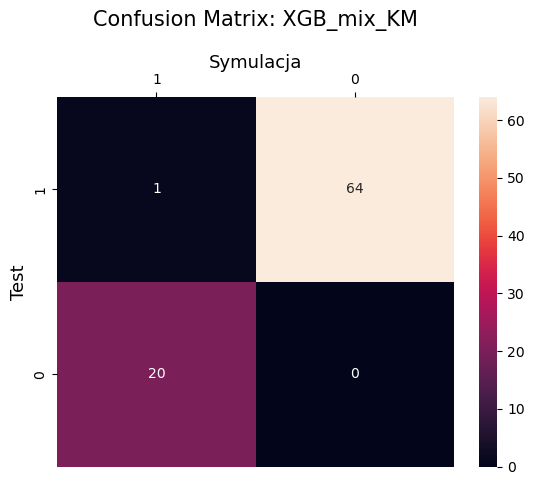

Confusion Matrix for XGB_smote_KM
[[ 0 65]
 [20  0]]
Classification Report for XGB_smote_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      65.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      85.0
   macro avg       0.00      0.00      0.00      85.0
weighted avg       0.00      0.00      0.00      85.0



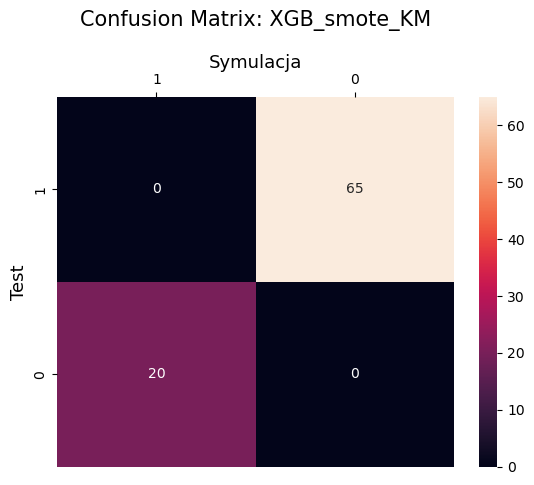

Confusion Matrix for XGB_GAN_KM
[[ 1 64]
 [14  6]]
Classification Report for XGB_GAN_KM
              precision    recall  f1-score   support

           0       0.07      0.02      0.03        65
           1       0.09      0.30      0.13        20

    accuracy                           0.08        85
   macro avg       0.08      0.16      0.08        85
weighted avg       0.07      0.08      0.05        85



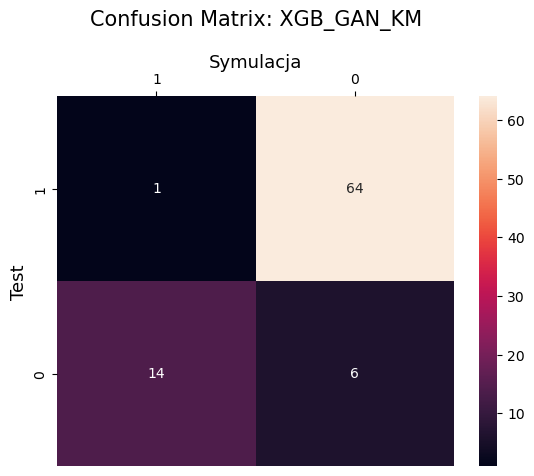

Confusion Matrix for XGB_borderline_KM
[[ 1 64]
 [20  0]]
Classification Report for XGB_borderline_KM
              precision    recall  f1-score   support

           0       0.05      0.02      0.02        65
           1       0.00      0.00      0.00        20

    accuracy                           0.01        85
   macro avg       0.02      0.01      0.01        85
weighted avg       0.04      0.01      0.02        85



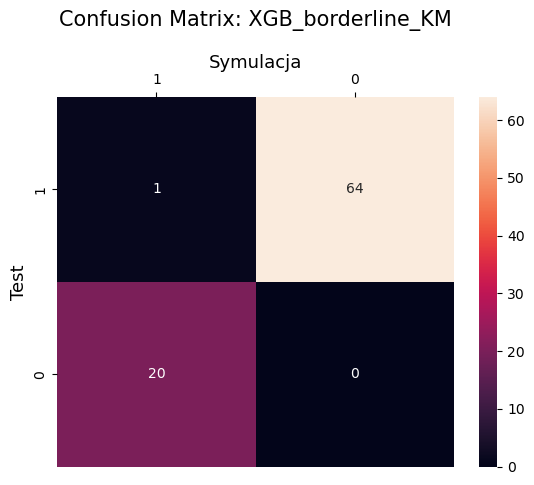

Confusion Matrix for XGB_mix_CC
[[64  1]
 [ 3 17]]
Classification Report for XGB_mix_CC
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.94      0.85      0.89        20

    accuracy                           0.95        85
   macro avg       0.95      0.92      0.93        85
weighted avg       0.95      0.95      0.95        85



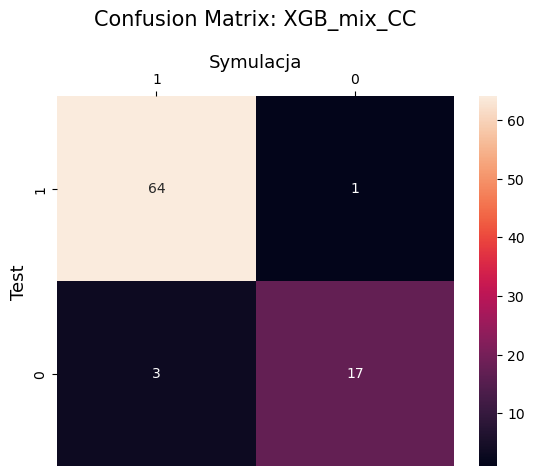

Confusion Matrix for XGB_smote_CC
[[64  1]
 [ 0 20]]
Classification Report for XGB_smote_CC
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.95      1.00      0.98        20

    accuracy                           0.99        85
   macro avg       0.98      0.99      0.98        85
weighted avg       0.99      0.99      0.99        85



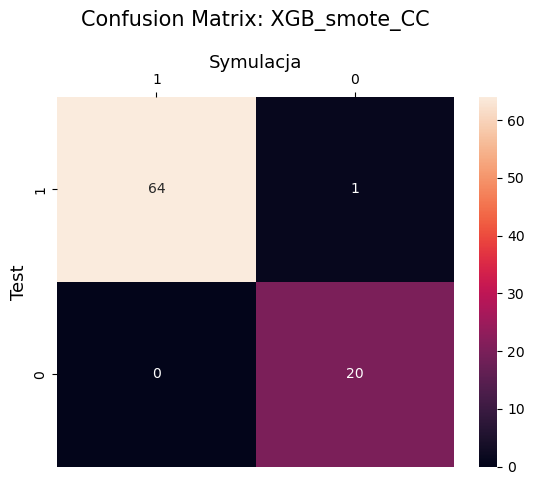

Confusion Matrix for XGB_GAN_CC
[[64  1]
 [ 3 17]]
Classification Report for XGB_GAN_CC
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.94      0.85      0.89        20

    accuracy                           0.95        85
   macro avg       0.95      0.92      0.93        85
weighted avg       0.95      0.95      0.95        85



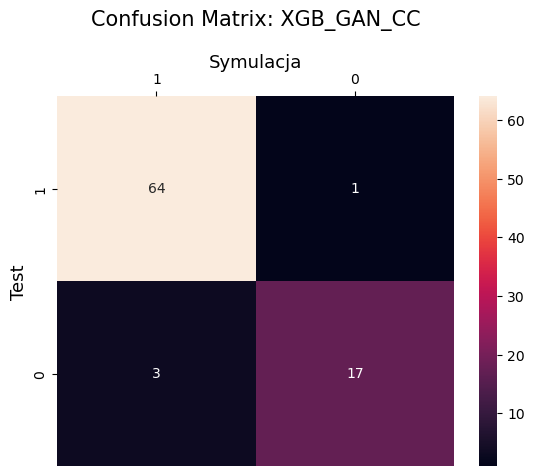

Confusion Matrix for XGB_borderline_CC
[[63  2]
 [ 0 20]]
Classification Report for XGB_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.91      1.00      0.95        20

    accuracy                           0.98        85
   macro avg       0.95      0.98      0.97        85
weighted avg       0.98      0.98      0.98        85



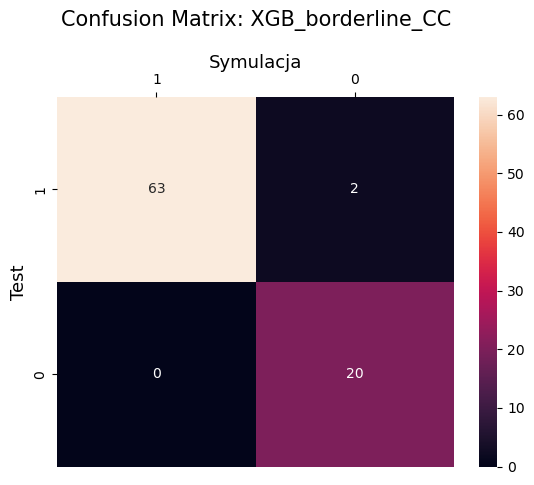

Confusion Matrix for XGBRF_mix_NM
[[62  3]
 [ 0 20]]
Classification Report for XGBRF_mix_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



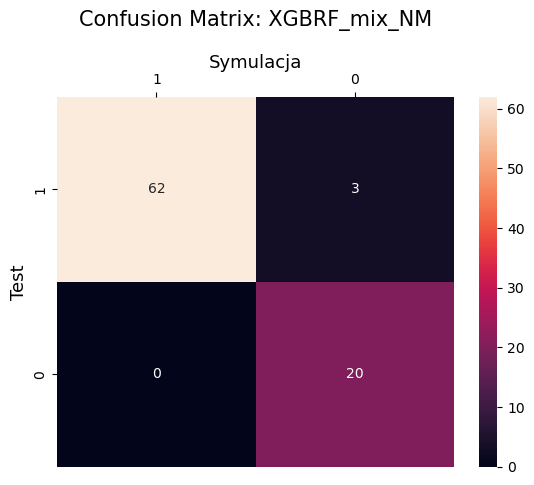

Confusion Matrix for XGBRF_smote_NM
[[62  3]
 [ 0 20]]
Classification Report for XGBRF_smote_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



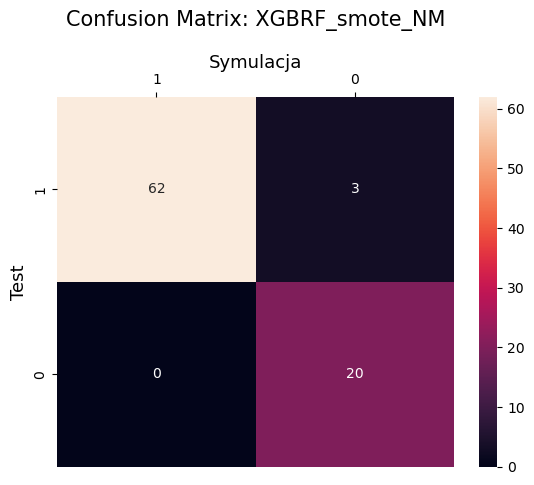

Confusion Matrix for XGBRF_GAN_NM
[[61  4]
 [ 0 20]]
Classification Report for XGBRF_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        65
           1       0.83      1.00      0.91        20

    accuracy                           0.95        85
   macro avg       0.92      0.97      0.94        85
weighted avg       0.96      0.95      0.95        85



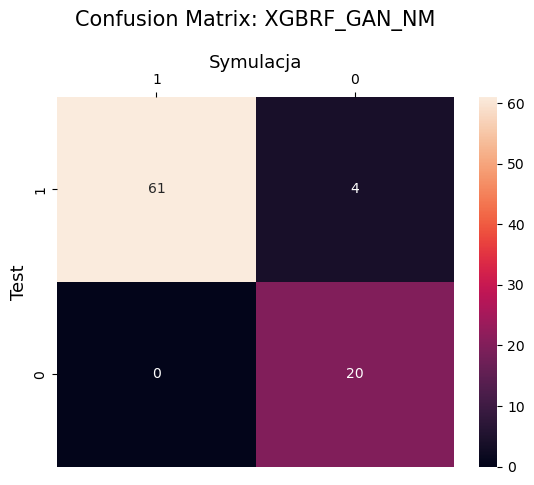

Confusion Matrix for XGBRF_borderline_NM
[[62  3]
 [ 0 20]]
Classification Report for XGBRF_borderline_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



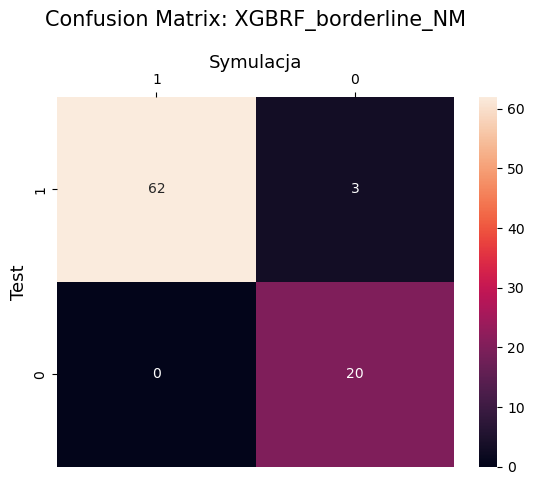

Confusion Matrix for XGBRF_mix_KM
[[ 5 60]
 [20  0]]
Classification Report for XGBRF_mix_KM
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        65
           1       0.00      0.00      0.00        20

    accuracy                           0.06        85
   macro avg       0.10      0.04      0.06        85
weighted avg       0.15      0.06      0.08        85



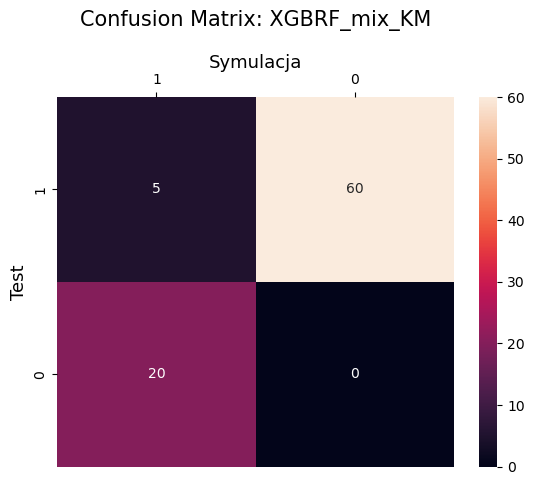

Confusion Matrix for XGBRF_smote_KM
[[ 5 60]
 [20  0]]
Classification Report for XGBRF_smote_KM
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        65
           1       0.00      0.00      0.00        20

    accuracy                           0.06        85
   macro avg       0.10      0.04      0.06        85
weighted avg       0.15      0.06      0.08        85



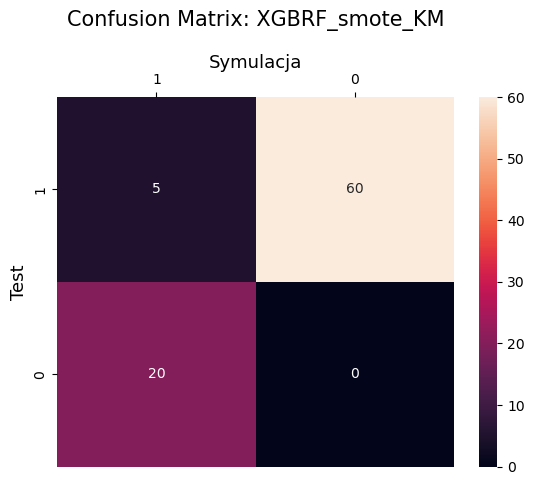

Confusion Matrix for XGBRF_GAN_KM
[[ 2 63]
 [16  4]]
Classification Report for XGBRF_GAN_KM
              precision    recall  f1-score   support

           0       0.11      0.03      0.05        65
           1       0.06      0.20      0.09        20

    accuracy                           0.07        85
   macro avg       0.09      0.12      0.07        85
weighted avg       0.10      0.07      0.06        85



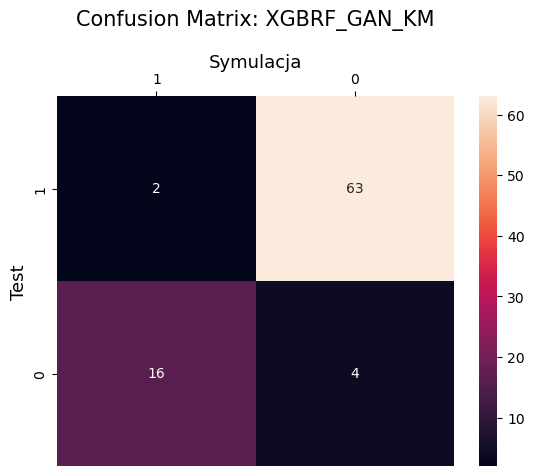

Confusion Matrix for XGBRF_borderline_KM
[[ 5 60]
 [20  0]]
Classification Report for XGBRF_borderline_KM
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        65
           1       0.00      0.00      0.00        20

    accuracy                           0.06        85
   macro avg       0.10      0.04      0.06        85
weighted avg       0.15      0.06      0.08        85



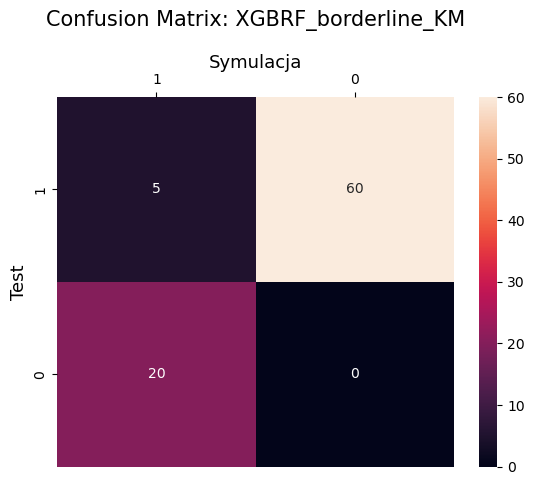

Confusion Matrix for XGBRF_mix_CC
[[59  6]
 [ 0 20]]
Classification Report for XGBRF_mix_CC
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        65
           1       0.77      1.00      0.87        20

    accuracy                           0.93        85
   macro avg       0.88      0.95      0.91        85
weighted avg       0.95      0.93      0.93        85



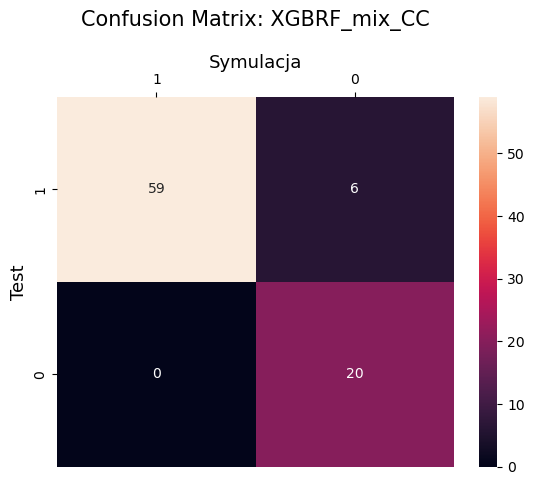

Confusion Matrix for XGBRF_smote_CC
[[62  3]
 [ 0 20]]
Classification Report for XGBRF_smote_CC
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        65
           1       0.87      1.00      0.93        20

    accuracy                           0.96        85
   macro avg       0.93      0.98      0.95        85
weighted avg       0.97      0.96      0.97        85



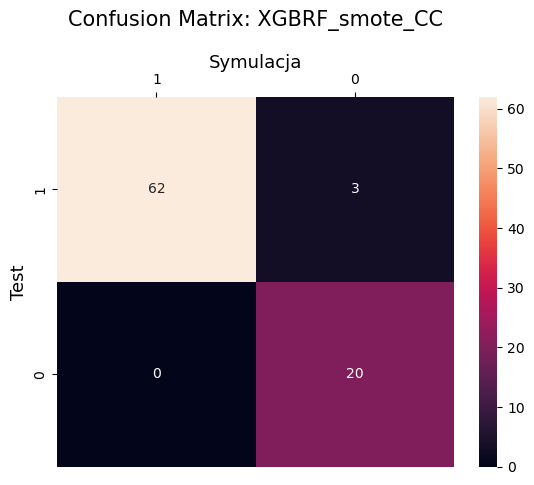

Confusion Matrix for XGBRF_GAN_CC
[[63  2]
 [ 1 19]]
Classification Report for XGBRF_GAN_CC
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        65
           1       0.90      0.95      0.93        20

    accuracy                           0.96        85
   macro avg       0.94      0.96      0.95        85
weighted avg       0.97      0.96      0.96        85



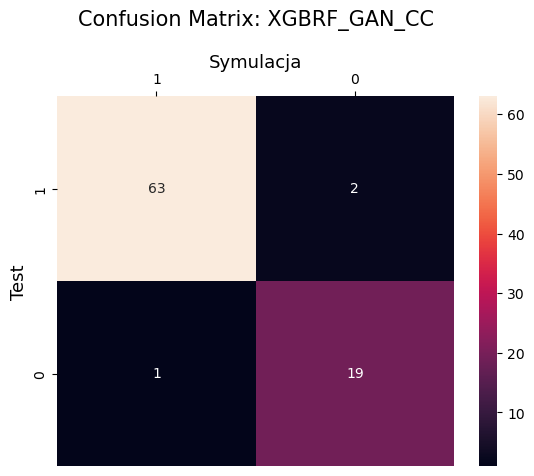

Confusion Matrix for XGBRF_borderline_CC
[[60  5]
 [ 0 20]]
Classification Report for XGBRF_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        65
           1       0.80      1.00      0.89        20

    accuracy                           0.94        85
   macro avg       0.90      0.96      0.92        85
weighted avg       0.95      0.94      0.94        85



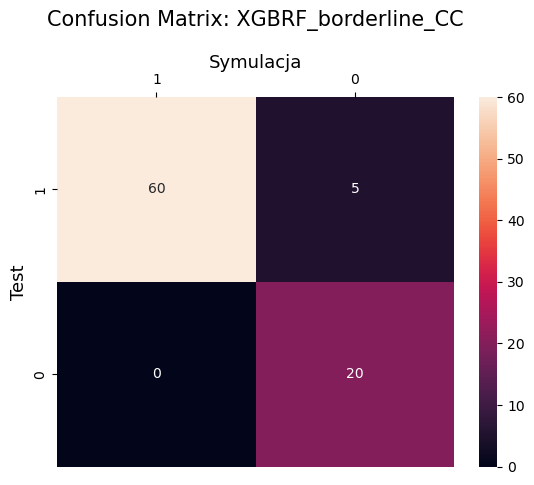

In [59]:
# generate reports + confusion matrix
for model_key, data_key in zip(models.keys(), training_data.keys()):
    X_train, y_train = training_data[data_key]
    
        # Load the best model using pickle
    model_filename = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_key}.joblib"
    with open(model_filename, 'rb') as model_file:
        best_model = load(model_file)
        
        best_model.fit(X_train, y_train)
        # Predict using the best model
        y_pred = best_model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_key}")
        print(cm)

        cr = classification_report(y_test, y_pred)
        print(f"Classification Report for {model_key}")
        print(cr)
        
        cf = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\confusion_matrix.txt"
        with open(cf, "a+") as f:
            # Zapis wyników do pliku
            print(f"Confusion Matrix for {model_key}", file=f)
            print(cm, file=f)
            print(f"Classification Report for {model_key}", file=f)
            print(cr, file=f)
        
        #make a heatmap
        sns.heatmap(cm, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
        plt.ylabel("Test", fontsize=13)
        plt.title(f"Confusion Matrix: {model_key}", fontsize=15, pad=20)
        plt.gca().xaxis.set_label_position("top")
        plt.xlabel("Symulacja", fontsize=13)
        plt.gca().xaxis.tick_top()
        plt.savefig(f'D:\\ml\\undersampling_data\\reports\\ssh\\results\\figures\\{model_key}.png', bbox_inches="tight", dpi=200)     
        plt.show()
        plt.close()  